In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("D:\\ML\\ECG CLASSIFICATION\\mitbih_train.csv\\mitbih_train.csv", header=None)
test_df=pd.read_csv("D:\\ML\\ECG CLASSIFICATION\\mitbih_test.csv\\mitbih_test.csv",header=None)

X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]  # Features & Labels
X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]  # Features & Labels

print("Train shape:", X_train.shape, "Labels:", y_train.shape)  # (num_train_samples, num_timesteps)
print("Test shape:", X_test.shape, "Labels:", y_test.shape)  # (num_test_samples, num_timesteps)


Train shape: (87554, 187) Labels: (87554,)
Test shape: (21892, 187) Labels: (21892,)


In [3]:
label_counts_imbalanced=train_df.iloc[:,-1].value_counts()

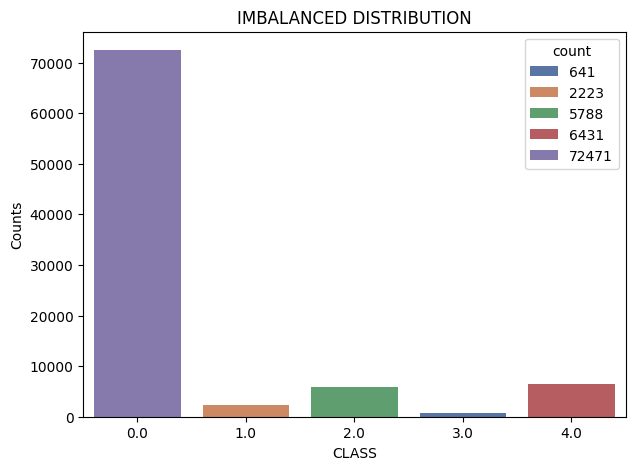

In [4]:
plt.figure(figsize=(7, 5))
sns.barplot(x=label_counts_imbalanced.index, y=label_counts_imbalanced.values,hue=label_counts_imbalanced,palette="deep")
plt.xlabel("CLASS")
plt.ylabel("Counts")
plt.title("IMBALANCED DISTRIBUTION")
plt.show()

In [5]:
from imblearn.combine import SMOTEENN

X_train_resampled, y_train_resampled = SMOTEENN(random_state=42).fit_resample(X_train, y_train)

In [6]:
from collections import Counter
print("Original train class distribution:", Counter(y_train))
print("New train class distribution:", Counter(y_train_resampled))

Original train class distribution: Counter({0.0: 72471, 4.0: 6431, 2.0: 5788, 1.0: 2223, 3.0: 641})
New train class distribution: Counter({3.0: 72471, 4.0: 72452, 1.0: 72438, 2.0: 72423, 0.0: 68980})


In [7]:
label_counts_balanced=y_train_resampled.value_counts()

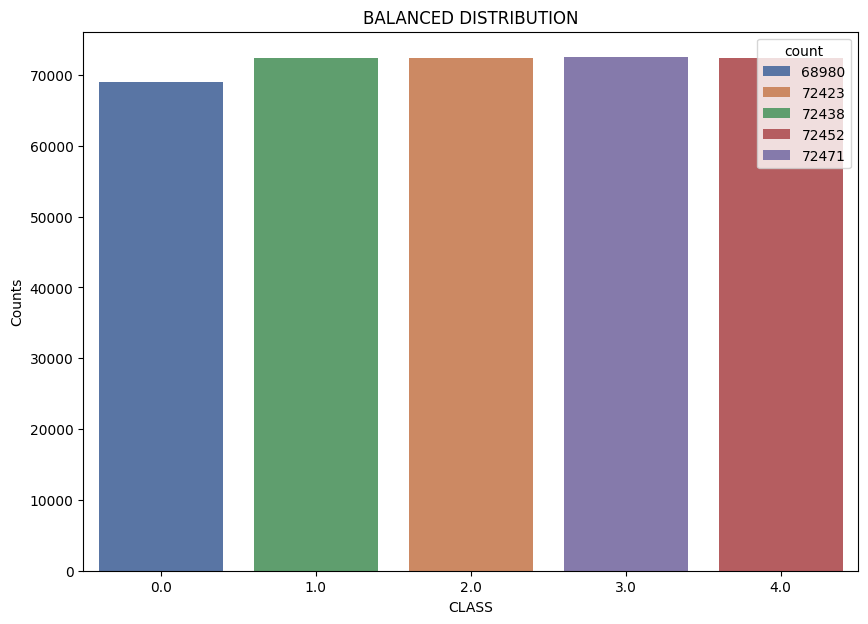

In [8]:
plt.figure(figsize=(10, 7))
sns.barplot(x=label_counts_balanced.index, y=label_counts_balanced.values,hue=label_counts_balanced,palette="deep")
plt.xlabel("CLASS")
plt.ylabel("Counts")
plt.title("BALANCED DISTRIBUTION")
plt.show()

In [9]:
def extract_time_features(ecg_signal):
    return {
        "mean": np.mean(ecg_signal),
        "std": np.std(ecg_signal),
        "rms": np.sqrt(np.mean(ecg_signal**2)),
        "entropy": -np.sum(ecg_signal * np.log(np.abs(ecg_signal) + 1e-10))  # Signal complexity
    }

In [10]:
import scipy.fftpack

def extract_fft_features(ecg_signal):
    fft_vals = np.abs(scipy.fftpack.fft(ecg_signal))
    spectral_entropy = -np.sum(fft_vals * np.log(fft_vals + 1e-10))
    return {
        "dominant_freq": np.argmax(fft_vals),
        "spectral_entropy": spectral_entropy
    }


In [11]:
import pywt

def extract_wavelet_features(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, 'db4', level=4)
    wavelet_features = []
    for coeff in coeffs:
        wavelet_features.append(np.mean(coeff))
        wavelet_features.append(np.std(coeff))
    return wavelet_features


In [12]:
def extract_features(X):
    feature_list = []

    for i in range(len(X)):  
        ecg_signal = X.iloc[i, :].values  

        features = {}
        features.update(extract_time_features(ecg_signal))
        features.update(extract_fft_features(ecg_signal))
        
        wavelet_feats = extract_wavelet_features(ecg_signal)
        
        for j in range(len(wavelet_feats) // 2):
            features[f"wavelet_mean_{j}"] = wavelet_feats[2 * j]
            features[f"wavelet_std_{j}"] = wavelet_feats[2 * j + 1]

        feature_list.append(features)

    return pd.DataFrame(feature_list)


In [13]:
X_train_features = extract_features(X_train_resampled)
X_test_features = extract_features(X_test)

X_train_features.to_csv("train_features_resampled3.csv", index=False)
X_test_features.to_csv("test_features_resampled3.csv", index=False)

print("Feature extraction complete")


Feature extraction complete


In [14]:
X_train_features.head()

,mean,std,rms,entropy,dominant_freq,spectral_entropy,wavelet_mean_0,wavelet_std_0,wavelet_mean_1,wavelet_std_1,wavelet_mean_2,wavelet_std_2,wavelet_mean_3,wavelet_std_3,wavelet_mean_4,wavelet_std_4
0,0.098419,0.176073,0.201713,24.068924,0,-340.238650,0.915172,0.973057,0.040314,0.222622,-0.017986,0.326057,-0.001263,0.092072,-0.001050,0.022465
1,0.090010,0.159722,0.183338,25.341530,0,-286.774401,0.801668,0.815015,0.045746,0.256476,-0.020623,0.316237,0.006891,0.099999,-0.001608,0.019330
2,0.062104,0.138769,0.152032,17.224721,0,-211.330878,0.596656,0.649967,0.064535,0.183890,-0.015464,0.287521,0.003689,0.114485,0.004120,0.035490
3,0.084084,0.160821,0.181476,20.933218,0,-273.276219,0.785370,0.839225,0.091388,0.297371,-0.023754,0.216928,0.007277,0.096107,0.002444,0.013934
4,0.116567,0.186151,0.219637,28.627752,0,-356.684691,1.125670,1.204141,-0.021977,0.290669,-0.031340,0.253893,-0.014618,0.056436,-0.000971,0.013421


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
# Train Random Forest
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train_features, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test_features)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9429471953224923
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     18118
         1.0       0.56      0.69      0.62       556
         2.0       0.80      0.89      0.84      1448
         3.0       0.52      0.71      0.60       162
         4.0       0.92      0.92      0.92      1608

    accuracy                           0.94     21892
   macro avg       0.75      0.83      0.79     21892
weighted avg       0.95      0.94      0.94     21892

Confusion Matrix:
 [[17378   286   266    81   107]
 [  159   382    11     1     3]
 [  114     7  1283    25    19]
 [   31     0    16   115     0]
 [   76     9    37     1  1485]]


In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train XGBoost
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
xgb_clf.fit(X_train_features, y_train_resampled)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test_features)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Accuracy: 0.9144436323771241
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.95     18118
         1.0       0.38      0.74      0.50       556
         2.0       0.74      0.91      0.81      1448
         3.0       0.31      0.82      0.45       162
         4.0       0.89      0.94      0.92      1608

    accuracy                           0.91     21892
   macro avg       0.66      0.87      0.73     21892
weighted avg       0.94      0.91      0.92     21892

Confusion Matrix:
 [[16653   665   395   255   150]
 [  118   412    17     3     6]
 [   73    11  1311    29    24]
 [   12     1    16   133     0]
 [   49     9    35     5  1510]]


<Axes: title={'center': 'CONFUSION MATRIX FOR RANDOM FOREST'}>

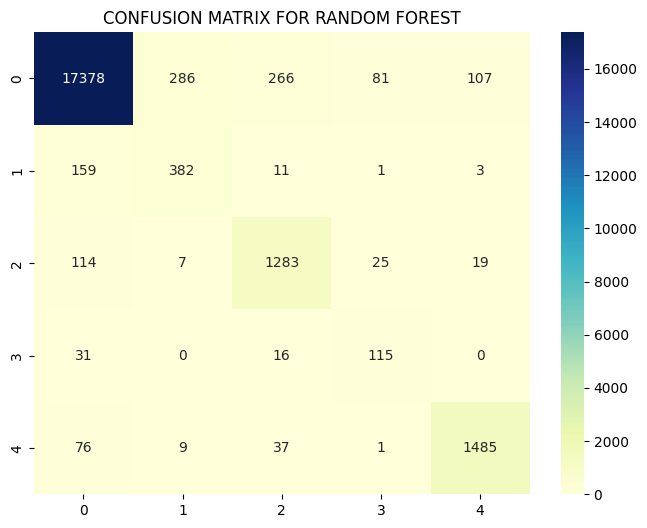

In [18]:
plt.figure(figsize=(8, 6))
cm_rf=confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("CONFUSION MATRIX FOR RANDOM FOREST")
sns.heatmap(cm_rf, annot=True,fmt="d",cmap="YlGnBu")

Text(70.72222222222221, 0.5, 'Actual')

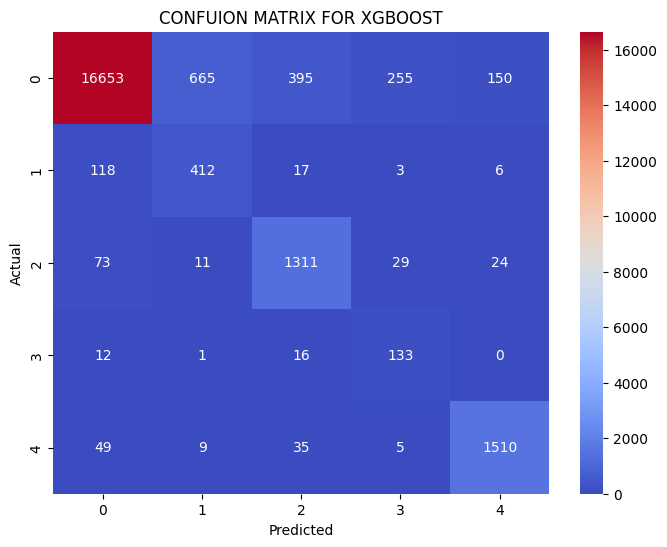

In [19]:
plt.figure(figsize=(8, 6))
cm_xg = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xg, annot=True,fmt="d",cmap="coolwarm")
plt.title('CONFUION MATRIX FOR XGBOOST')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# TRAINING USING IMBALANCED DATASET

In [20]:
X_train_features_im = extract_features(X_train)
X_test_features_im = extract_features(X_test)

X_train_features.to_csv("train_features_resampled3.csv", index=False)
X_test_features.to_csv("test_features_resampled3.csv", index=False)

print("Feature extraction complete")

Feature extraction complete


In [21]:
X_train_features_im.head()

,mean,std,rms,entropy,dominant_freq,spectral_entropy,wavelet_mean_0,wavelet_std_0,wavelet_mean_1,wavelet_std_1,wavelet_mean_2,wavelet_std_2,wavelet_mean_3,wavelet_std_3,wavelet_mean_4,wavelet_std_4
0,0.098419,0.176073,0.201713,24.068924,0,-340.238650,0.915172,0.973057,0.040314,0.222622,-0.017986,0.326057,-0.001263,0.092072,-0.001050,0.022465
1,0.090010,0.159722,0.183338,25.341530,0,-286.774401,0.801668,0.815015,0.045746,0.256476,-0.020623,0.316237,0.006891,0.099999,-0.001608,0.019330
2,0.062104,0.138769,0.152032,17.224721,0,-211.330878,0.596656,0.649967,0.064535,0.183890,-0.015464,0.287521,0.003689,0.114485,0.004120,0.035490
3,0.084084,0.160821,0.181476,20.933218,0,-273.276219,0.785370,0.839225,0.091388,0.297371,-0.023754,0.216928,0.007277,0.096107,0.002444,0.013934
4,0.116567,0.186151,0.219637,28.627752,0,-356.684691,1.125670,1.204141,-0.021977,0.290669,-0.031340,0.253893,-0.014618,0.056436,-0.000971,0.013421


In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train XGBoost
xgb_clf_im = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
xgb_clf_im.fit(X_train_features_im, y_train)

# Predictions
y_pred_xgb_im = xgb_clf_im.predict(X_test_features_im)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_im))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_im))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_im))


Accuracy: 0.9613557463913759
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     18118
         1.0       0.90      0.56      0.69       556
         2.0       0.90      0.84      0.87      1448
         3.0       0.83      0.59      0.69       162
         4.0       0.97      0.92      0.94      1608

    accuracy                           0.96     21892
   macro avg       0.91      0.78      0.83     21892
weighted avg       0.96      0.96      0.96     21892

Confusion Matrix:
 [[17952    32    94     8    32]
 [  235   310    11     0     0]
 [  197     2  1216    12    21]
 [   56     0    11    95     0]
 [  110     0    25     0  1473]]


<Axes: title={'center': 'Confusion Matrix for XGBOOST'}>

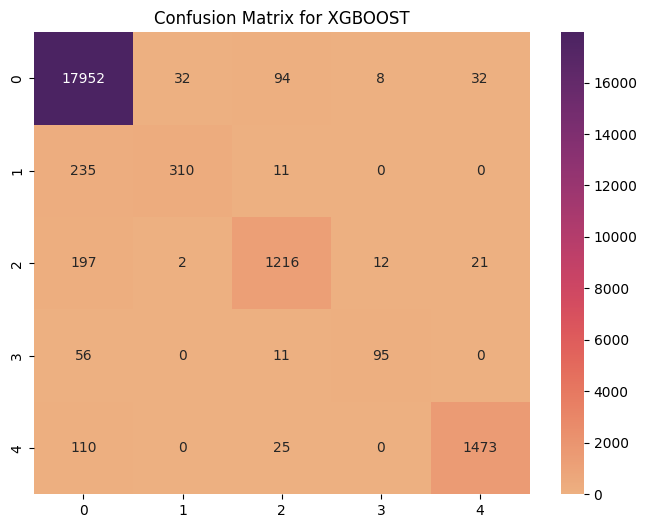

In [23]:
plt.figure(figsize=(8, 6))
cm_rf_im=confusion_matrix(y_test, y_pred_xgb_im)
plt.title('Confusion Matrix for XGBOOST')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sns.heatmap(cm_rf_im, annot=True,fmt="d",cmap="flare")

In [24]:
clf_im = RandomForestClassifier(n_estimators=10, random_state=42)
clf_im.fit(X_train_features_im, y_train)

# Predictions
y_pred_im = clf_im.predict(X_test_features_im)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_im))
print("Classification Report:\n", classification_report(y_test, y_pred_im))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_im))

Accuracy: 0.9535446738534624
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     18118
         1.0       0.93      0.46      0.62       556
         2.0       0.89      0.80      0.84      1448
         3.0       0.83      0.35      0.49       162
         4.0       0.97      0.88      0.92      1608

    accuracy                           0.95     21892
   macro avg       0.92      0.70      0.77     21892
weighted avg       0.95      0.95      0.95     21892

Confusion Matrix:
 [[17992    19    79     3    25]
 [  292   256     8     0     0]
 [  266     1  1153     9    19]
 [   96     0     9    57     0]
 [  151     0    40     0  1417]]


<Axes: title={'center': 'Confusion Matrix for RANDOM FOREST'}>

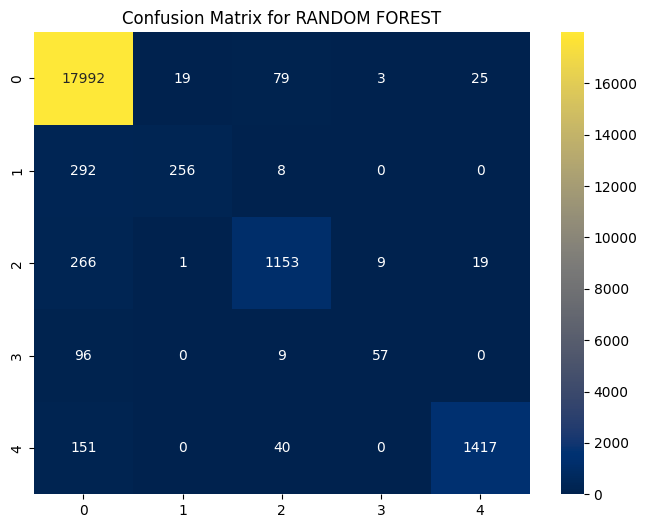

In [25]:
plt.figure(figsize=(8, 6))
cm_rf_im=confusion_matrix(y_test, y_pred_im)
plt.title('Confusion Matrix for RANDOM FOREST')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sns.heatmap(cm_rf_im, annot=True,fmt="d",cmap="cividis")

# Multiclass ROC-AUC Curve Comparison Across Models

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

my_labels=[0,1,2,3,4]
y_test_bin = label_binarize(y_test, classes=my_labels)

In [27]:
xgb_im_proba = xgb_clf_im.predict_proba(X_test_features_im)
rf_im_proba = clf_im.predict_proba(X_test_features_im)
xgb_proba = xgb_clf.predict_proba(X_test_features)
rf_proba = clf.predict_proba(X_test_features)


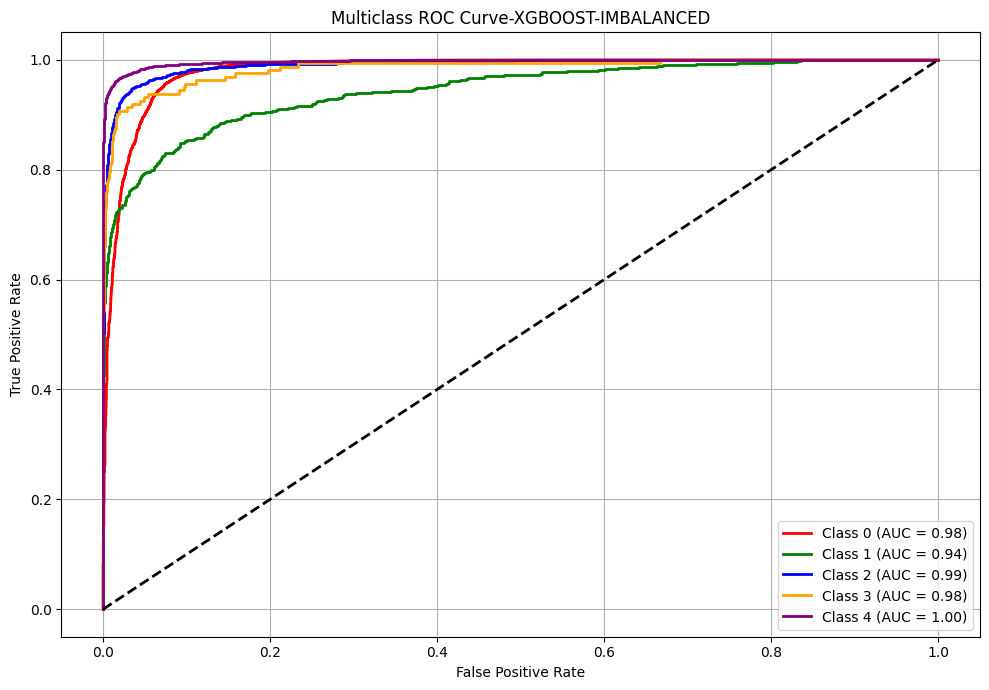

In [28]:
fpr_xgb_im = dict()
tpr_xgb_im = dict()
roc_auc1 = dict()

#Calculation of ROC and AUC for each Class
for i in range(len(my_labels)):
    fpr_xgb_im[i], tpr_xgb_im[i], _ = roc_curve(y_test_bin[:, i], xgb_im_proba[:, i])
    roc_auc1[i] = auc(fpr_xgb_im[i], tpr_xgb_im[i])


plt.figure(figsize=(10, 7))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])

for i, color in zip(range(5), colors):
    plt.plot(fpr_xgb_im[i], tpr_xgb_im[i], color=color, lw=2,
             label=f'Class {my_labels[i]} (AUC = {roc_auc1[i]:.2f})')

# Diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve-XGBOOST-IMBALANCED')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

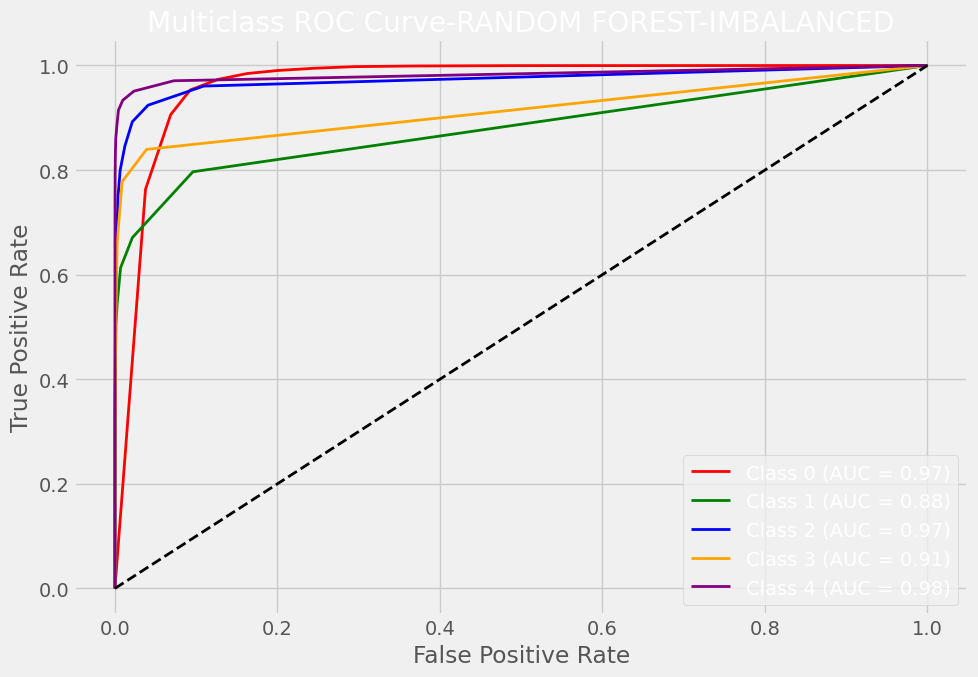

In [39]:
fpr_rf_im = dict()
tpr_rf_im = dict()
roc_auc2 = dict()

#Calculation of ROC and AUC for each Class
for i in range(len(my_labels)):
    fpr_rf_im[i], tpr_rf_im[i], _ = roc_curve(y_test_bin[:, i], rf_im_proba[:, i])
    roc_auc2[i] = auc(fpr_rf_im[i], tpr_rf_im[i])


plt.figure(figsize=(10, 7))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])

for i, color in zip(range(5), colors):
    plt.plot(fpr_rf_im[i], tpr_rf_im[i], color=color, lw=2,
             label=f'Class {my_labels[i]} (AUC = {roc_auc2[i]:.2f})')

# Diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve-RANDOM FOREST-IMBALANCED')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

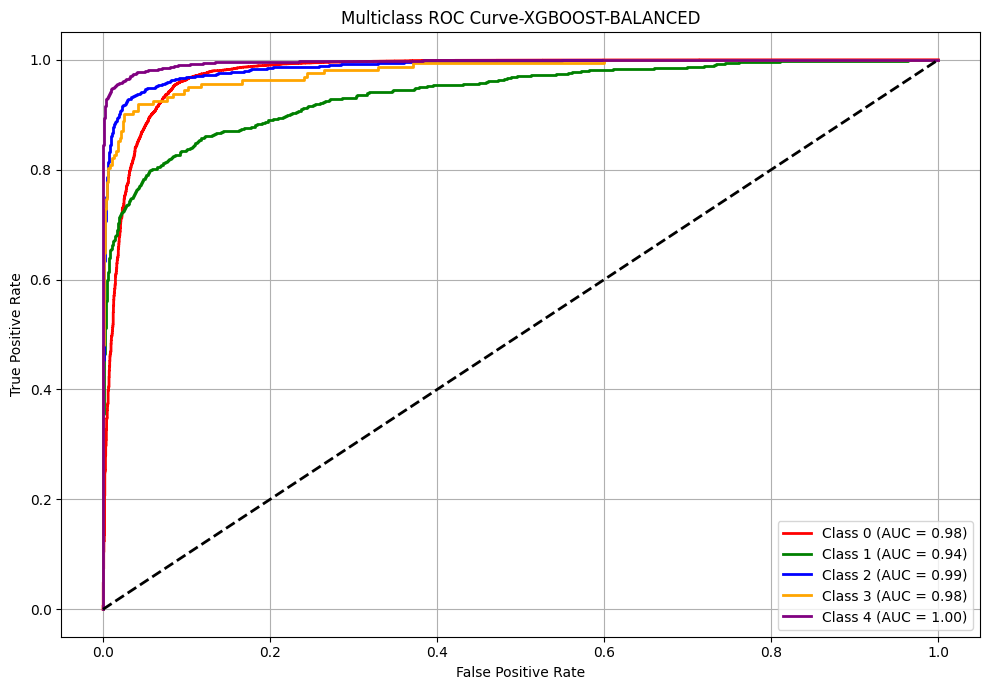

In [30]:
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc3 = dict()

#Calculation of ROC and AUC for each Class
for i in range(len(my_labels)):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_bin[:, i], xgb_proba[:, i])
    roc_auc3[i] = auc(fpr_xgb[i], tpr_xgb[i])


plt.figure(figsize=(10, 7))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])

for i, color in zip(range(5), colors):
    plt.plot(fpr_xgb[i], tpr_xgb[i], color=color, lw=2,
             label=f'Class {my_labels[i]} (AUC = {roc_auc3[i]:.2f})')

# Diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve-XGBOOST-BALANCED')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

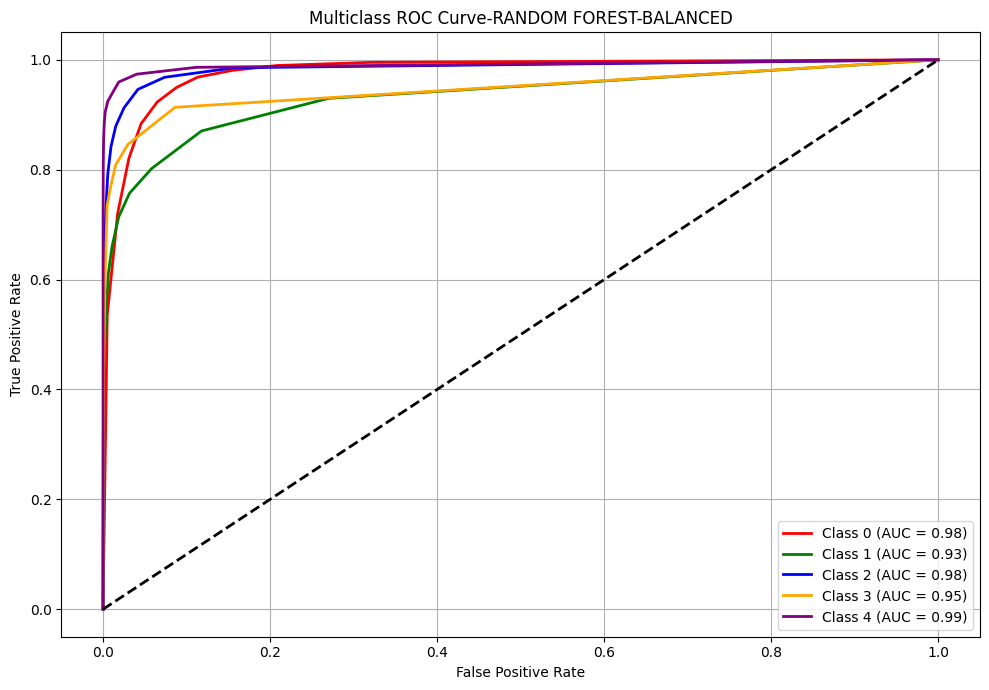

In [31]:
fpr_rf = dict()
tpr_rf = dict()
roc_auc4 = dict()

#Calculation of ROC and AUC for each Class
for i in range(len(my_labels)):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], rf_proba[:, i])
    roc_auc4[i] = auc(fpr_rf[i], tpr_rf[i])


plt.figure(figsize=(10, 7))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])

for i, color in zip(range(5), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2,
             label=f'Class {my_labels[i]} (AUC = {roc_auc4[i]:.2f})')

# Diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve-RANDOM FOREST-BALANCED')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

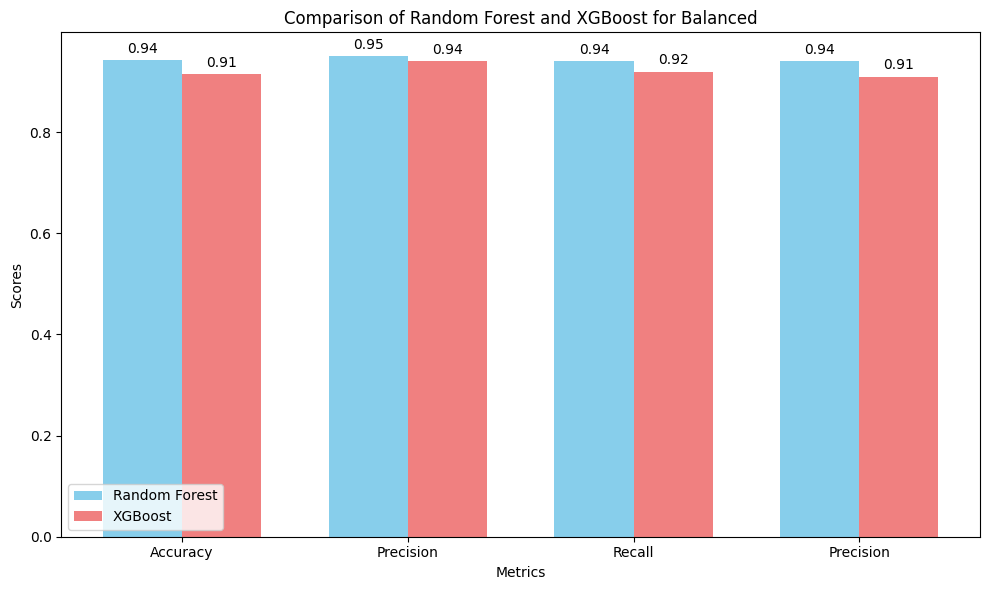

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Random Forest
accuracy_rf = 0.9429471953224923
precision_rf = 0.95  # Macro average precision
recall_rf = 0.94     # Macro average recall
weighted_precision_rf = 0.94  # Weighted average precision

# Metrics for XGBoost
accuracy_xgb = 0.9144436323771241
precision_xgb = 0.94  # Macro average precision
recall_xgb = 0.92    # Macro average recall
weighted_precision_xgb = 0.91  # Weighted average precision

# Labels for the metrics
labels = ['Accuracy', 'Precision', 'Recall', 'Precision']

# Values for Random Forest and XGBoost
rf_values = [accuracy_rf, precision_rf, recall_rf, weighted_precision_rf]
xgb_values = [accuracy_xgb, precision_xgb, recall_xgb, weighted_precision_xgb]

# Set up the positions for the bars
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Random Forest and XGBoost
rects1 = ax.bar(x - width/2, rf_values, width, label='Random Forest', color='skyblue')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Random Forest and XGBoost for Balanced')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to both sets of bars
add_labels(rects1)
add_labels(rects2)

# Display the plot
plt.tight_layout()
plt.show()


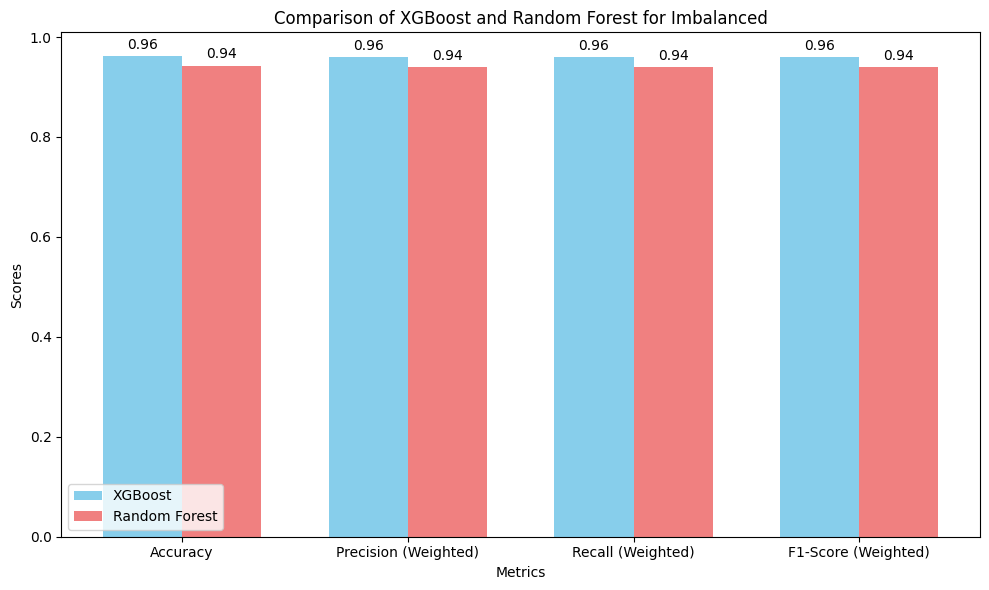

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for XGBoost
accuracy_xgb = 0.9613557463913759
precision_xgb = 0.96  # Weighted average precision
recall_xgb = 0.96     # Weighted average recall
f1_xgb = 0.96         # Weighted average F1-score

# Metrics for Random Forest
accuracy_rf = 0.9429471953224923
precision_rf = 0.94  # Weighted average precision
recall_rf = 0.94     # Weighted average recall
f1_rf = 0.94         # Weighted average F1-score

# Labels for the metrics
labels = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']

# Values for XGBoost and Random Forest
xgb_values = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]
rf_values = [accuracy_rf, precision_rf, recall_rf, f1_rf]

# Set up the positions for the bars
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for XGBoost and Random Forest
rects1 = ax.bar(x - width/2, xgb_values, width, label='XGBoost', color='skyblue')
rects2 = ax.bar(x + width/2, rf_values, width, label='Random Forest', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of XGBoost and Random Forest for Imbalanced')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to both sets of bars
add_labels(rects1)
add_labels(rects2)

# Display the plot
plt.tight_layout()
plt.show()
